<a href="https://colab.research.google.com/github/Fuenfgeld/DMA2022TeamA/blob/main/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
reset -f


**Import der Libraries und Verbindung mit Google Drive und Sqlite3**

In [2]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
import datetime

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def connect_to_db(db_file):
    sqlite3_conn = None
    try:
        sqlite3_conn = sq.connect(db_file)
        return sqlite3_conn

    except Error as err:
        print(err)

        if sqlite3_conn is not None:
            sqlite3_conn.close()
  
conn_dwh = sqlite3.connect('/content/drive/Shareddrives/Gruppe A/Datawarehouse.db')


**Erstellen eines Ursprungsdataframes aus dem Datawarehouse**




In [5]:
df = pd.read_sql_query("""
select t1.*, dimObservations.id as OBSERVATION_ID, dimObservations.code, dimObservations.description, dimObservations.value, dimObservations.units, dimObservations.date from dimObservations
left JOIN
(select Zentrum.observation_id, Zentrum.patient_id, dimPatients.dataset_origin from Zentrum, dimPatients where Zentrum.patient_id = dimPatients.id) t1
on dimObservations.id = t1.observation_id
;""", conn_dwh
  )

In [6]:
df.head(3)

,observation_id,patient_id,dataset_origin,OBSERVATION_ID,CODE,DESCRIPTION,VALUE,UNITS,DATE
0,5,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,allergy,5,8462-4,Diastolic Blood Pressure,82.0,mm[Hg],2011-04-11T11:40:19Z
1,6,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,allergy,6,8480-6,Systolic Blood Pressure,110.0,mm[Hg],2011-04-11T11:40:19Z
2,7,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,allergy,7,8867-4,Heart rate,65.0,/min,2011-04-11T11:40:19Z


In [7]:
#Entfernen von Duplikaten
df.drop_duplicates(keep="first",inplace=True) 
print("Size of dataset after removing duplicated rows", df.shape)

Size of dataset after removing duplicated rows (39844, 9)


In [8]:
# Übersicht 
df.nunique(axis=0)

observation_id    39844
patient_id         1051
dataset_origin        3
OBSERVATION_ID    39844
CODE                 15
DESCRIPTION          16
VALUE              1906
UNITS                 9
DATE               5785
dtype: int64

In [9]:
#Ursprung der Daten
df.groupby(["dataset_origin"]).size()

dataset_origin
allergy              10945
colorectal_cancer      372
covid19              28527
dtype: int64

**Erstellen eines Dataframes, der nur Angaben zu COVID-positiven Patienten enthält. Diese werden in einer zusätzlichen Spalte mit "1" bezeichnet**





In [10]:
#Zunächst Selektion der positiven Testergebnisse
dfpostest = df.loc[(df["CODE"] == "94531-1") & (df["VALUE"] == "Detected (qualifier value)")] 
dfpostest.head(3)



,observation_id,patient_id,dataset_origin,OBSERVATION_ID,CODE,DESCRIPTION,VALUE,UNITS,DATE
54,140,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,allergy,140,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),None,2020-03-10T12:31:19Z
296,900,aff157cc-b6d3-412b-ccbe-bfd5fac1c2d5,allergy,900,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),None,2020-03-07T02:02:18Z
350,1061,28124841-1cf3-2818-d4ee-8574fac23298,allergy,1061,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),None,2020-02-28T00:30:05Z


In [11]:
# Erstellen eines Dataframes mit allen Laborwerten der Patienten mit positivem Testergebnis
dfpos = df.loc[((df.patient_id.isin(dfpostest['patient_id'])))]


In [12]:
# Löschen der Patienten mit COVID-Nebendiagnse aus dem ALLERGY-Dataset, da diese zahlreiche nicht mit der COVID-Infektion im Zusammenhang stehende (ältere) Laborparameter haben
dfpos = dfpos.drop( dfpos[ dfpos['dataset_origin'] == "allergy" ].index)

In [13]:
# Hinzufügen einer zusätzlichen Spalte mit dem Wert "1"
dfpos['Covid'] = '1'
dfpos.head(3)

,observation_id,patient_id,dataset_origin,OBSERVATION_ID,CODE,DESCRIPTION,VALUE,UNITS,DATE,Covid
53974,143480,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143480,8310-5,Body temperature,41.4,Cel,2020-02-17T21:57:21Z,1
53976,143481,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143481,9279-1,Respiratory rate,21.4,/min,2020-02-17T21:57:21Z,1
53978,143482,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143482,8867-4,Heart rate,61.6,/min,2020-02-17T21:57:21Z,1


In [14]:
#Übersicht der Covid-Kohorte
dfpos.nunique(axis=0)

observation_id    28247
patient_id          865
dataset_origin        1
OBSERVATION_ID    28247
CODE                 15
DESCRIPTION          15
VALUE              1873
UNITS                 8
DATE               3481
Covid                 1
dtype: int64

**Erstellen eines Dataframes, der nur die Patienten der Kontrollgruppe beinhaltet. Diese werden in einer zusätzlichen Spalte mit "0" bezeichnet**

In [15]:
#Selektion der Laborparameter von Patienten ohne positiven COVID-Test aus dem Ursprungsdataframe
dfneg = df.loc[~((df.patient_id.isin(dfpostest['patient_id'])))]
dfneg.head(3)

,observation_id,patient_id,dataset_origin,OBSERVATION_ID,CODE,DESCRIPTION,VALUE,UNITS,DATE
72,192,17f0c6d9-8931-8839-66cb-3ca6fb066d3e,allergy,192,8462-4,Diastolic Blood Pressure,78.0,mm[Hg],2011-06-12T16:56:37Z
73,193,17f0c6d9-8931-8839-66cb-3ca6fb066d3e,allergy,193,8480-6,Systolic Blood Pressure,115.0,mm[Hg],2011-06-12T16:56:37Z
74,194,17f0c6d9-8931-8839-66cb-3ca6fb066d3e,allergy,194,8867-4,Heart rate,77.0,/min,2011-06-12T16:56:37Z


In [16]:
dfneg.shape

(5427, 9)

In [17]:
# Erstellen eines Dataframes von Patienten mit der Nebendiagnose Covid19 
dfNebendiag = pd.read_sql_query("""
select patient_id, CODE, DESCRIPTION from dimConditions where code in ("840539006")
;""", conn_dwh
  )


In [18]:
dfNebendiag.head(3)

,PATIENT_ID,CODE,DESCRIPTION
0,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,840539006,COVID-19
1,aff157cc-b6d3-412b-ccbe-bfd5fac1c2d5,840539006,COVID-19
2,28124841-1cf3-2818-d4ee-8574fac23298,840539006,COVID-19


In [19]:
# Um Sicherzugehen, dass wirklich nur Covid-neg. Patienten in der Kontrollgruppe sind werden auch Patienten ohne Testergebnis aber mit Nebendiagnose Covid19 bzw. Verdacht auf Covid19 ausgeschlossen.
dfneg = dfneg.loc[~((dfneg.patient_id.isin(dfNebendiag["PATIENT_ID"])))]


In [20]:
# Hinzufügen Spalte mit Wert "0"
dfneg['Covid'] = '0'
dfneg.head(3)

,observation_id,patient_id,dataset_origin,OBSERVATION_ID,CODE,DESCRIPTION,VALUE,UNITS,DATE,Covid
72,192,17f0c6d9-8931-8839-66cb-3ca6fb066d3e,allergy,192,8462-4,Diastolic Blood Pressure,78.0,mm[Hg],2011-06-12T16:56:37Z,0
73,193,17f0c6d9-8931-8839-66cb-3ca6fb066d3e,allergy,193,8480-6,Systolic Blood Pressure,115.0,mm[Hg],2011-06-12T16:56:37Z,0
74,194,17f0c6d9-8931-8839-66cb-3ca6fb066d3e,allergy,194,8867-4,Heart rate,77.0,/min,2011-06-12T16:56:37Z,0


In [21]:
dfneg.shape

(5427, 10)

In [22]:
#Übersicht Kontrolgruppe
dfneg.nunique(axis=0)

observation_id    5427
patient_id         100
dataset_origin       3
OBSERVATION_ID    5427
CODE                14
DESCRIPTION         15
VALUE              964
UNITS                9
DATE              1070
Covid                1
dtype: int64

**Zusammenfügen von COVID-pos. Kohorte und Kontrollgruppe in einen Dataframe**

In [23]:
dffinal = pd.concat([dfpos, dfneg])
dffinal.head(3)

,observation_id,patient_id,dataset_origin,OBSERVATION_ID,CODE,DESCRIPTION,VALUE,UNITS,DATE,Covid
53974,143480,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143480,8310-5,Body temperature,41.4,Cel,2020-02-17T21:57:21Z,1
53976,143481,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143481,9279-1,Respiratory rate,21.4,/min,2020-02-17T21:57:21Z,1
53978,143482,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143482,8867-4,Heart rate,61.6,/min,2020-02-17T21:57:21Z,1


In [24]:
# Löschen der COVID-Testergebnisse, damit der Datentyp der Werte der Spalte "Value" in Floats geändert werden kann (Covid-Status ist trotzdem in Spalte Covid festgehalten)
dffinal = dffinal.loc[(dffinal["CODE"] != "94531-1")]


# Konvertieren der Laborwerte und des Covid-Status in Zahlenwerte (Floats)
dffinal["Covid"] = dffinal["Covid"].astype("float")
dffinal["VALUE"] = dffinal["VALUE"].astype("float")

dffinal.head(3)

,observation_id,patient_id,dataset_origin,OBSERVATION_ID,CODE,DESCRIPTION,VALUE,UNITS,DATE,Covid
53974,143480,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143480,8310-5,Body temperature,41.4,Cel,2020-02-17T21:57:21Z,1.0
53976,143481,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143481,9279-1,Respiratory rate,21.4,/min,2020-02-17T21:57:21Z,1.0
53978,143482,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143482,8867-4,Heart rate,61.6,/min,2020-02-17T21:57:21Z,1.0


In [25]:
#Konvertieren der Datumformats 
dffinal["DATE"] = pd.to_datetime(dffinal["DATE"])
dffinal["DATE"] = dffinal["DATE"].dt.to_period('d')

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [26]:
dffinal.head()

,observation_id,patient_id,dataset_origin,OBSERVATION_ID,CODE,DESCRIPTION,VALUE,UNITS,DATE,Covid
53974,143480,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143480,8310-5,Body temperature,41.4,Cel,2020-02-17,1.0
53976,143481,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143481,9279-1,Respiratory rate,21.4,/min,2020-02-17,1.0
53978,143482,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143482,8867-4,Heart rate,61.6,/min,2020-02-17,1.0
53980,143483,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143483,2708-6,Oxygen saturation in Arterial blood,77.4,%,2020-02-17,1.0
53982,143484,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143484,8462-4,Diastolic Blood Pressure,85.0,mm[Hg],2020-02-17,1.0


**Vergleichende Analyse der Laborparameter zwischen den Gruppen**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 81.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


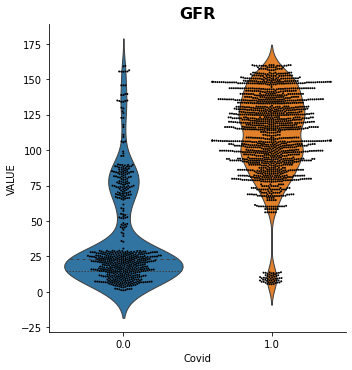

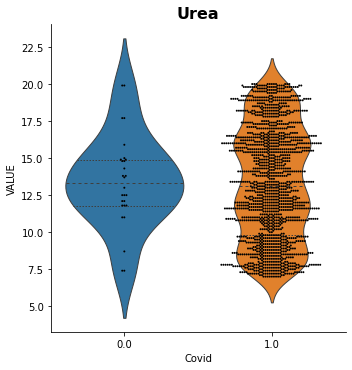

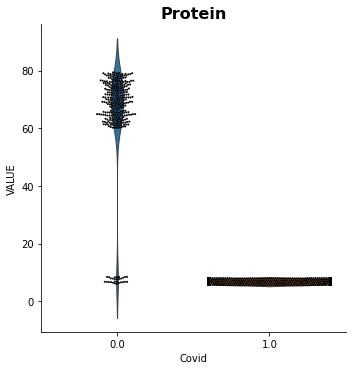

In [27]:
%matplotlib inline
#Plotting der Nierenparameter
GFR= dffinal[dffinal['CODE'] == "33914-3"]
Urea= dffinal[dffinal['CODE'] == "3094-0"]
Protein= dffinal[dffinal['CODE'] == "2885-2"]

g = sns.catplot(data=GFR, x="Covid", y="VALUE", kind="violin", inner="quart", linewidth=1)
sns.swarmplot(data=GFR, x="Covid", y="VALUE", color="k", size=2, ax=g.ax)
plt.title('GFR', weight='bold').set_fontsize('16')

g = sns.catplot(data=Urea, x="Covid", y="VALUE", kind="violin", inner="quart", linewidth=1)
sns.swarmplot(data=Urea, x="Covid", y="VALUE", color="k", size=2, ax=g.ax)
plt.title('Urea', weight='bold').set_fontsize('16')

g = sns.catplot(data=Protein, x="Covid", y="VALUE", kind="violin", inner="quart", linewidth=1)
sns.swarmplot(data=Protein, x="Covid", y="VALUE", color="k", size=2, ax=g.ax)
plt.title('Protein', weight='bold').set_fontsize('16')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 55.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 21.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 54.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


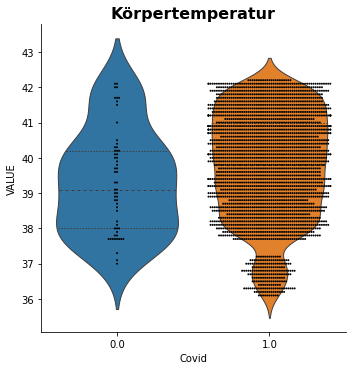

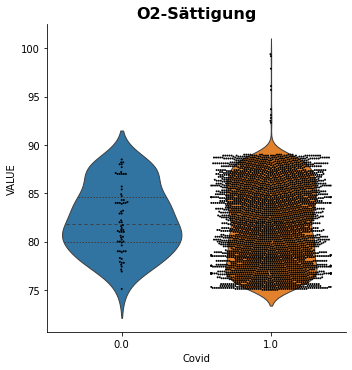

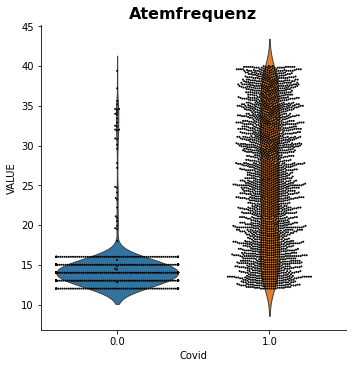

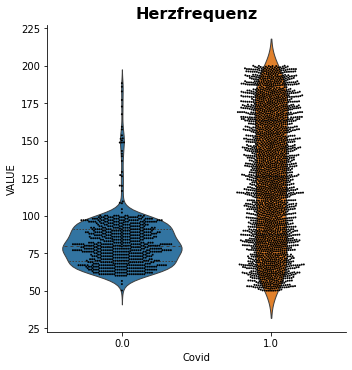

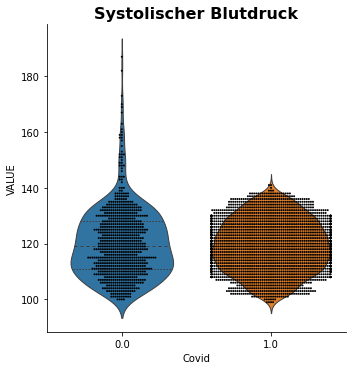

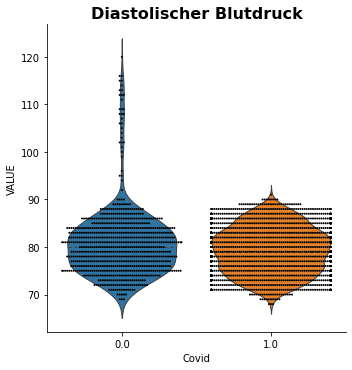

In [28]:
#Plotting der Kreislaufparameter
Temperatur= dffinal[dffinal['CODE'] == "8310-5"]
O2= dffinal[dffinal['CODE'] == "2708-6"]
AF= dffinal[dffinal['CODE'] == "9279-1"]
HF= dffinal[dffinal['CODE'] == "8867-4"]
Syst= dffinal[dffinal['CODE'] == "8480-6"]
Dia= dffinal[dffinal['CODE'] == "8462-4"]

g = sns.catplot(data=Temperatur, x="Covid", y="VALUE", kind="violin", inner="quart", linewidth=1)
sns.swarmplot(data=Temperatur, x="Covid", y="VALUE", color="k", size=2, ax=g.ax)
plt.title('Körpertemperatur', weight='bold').set_fontsize('16')

g = sns.catplot(data=O2, x="Covid", y="VALUE", kind="violin", inner="quart", linewidth=1)
sns.swarmplot(data=O2, x="Covid", y="VALUE", color="k", size=2, ax=g.ax)
plt.title('O2-Sättigung', weight='bold').set_fontsize('16')

g = sns.catplot(data=AF, x="Covid", y="VALUE", kind="violin", inner="quart", linewidth=1)
sns.swarmplot(data=AF, x="Covid", y="VALUE", color="k", size=2, ax=g.ax)
plt.title('Atemfrequenz', weight='bold').set_fontsize('16')

g = sns.catplot(data=HF, x="Covid", y="VALUE", kind="violin", inner="quart", linewidth=1)
sns.swarmplot(data=HF, x="Covid", y="VALUE", color="k", size=2, ax=g.ax)
plt.title('Herzfrequenz', weight='bold').set_fontsize('16')

g = sns.catplot(data=Syst, x="Covid", y="VALUE", kind="violin", inner="quart", linewidth=1)
sns.swarmplot(data=Syst, x="Covid", y="VALUE", color="k", size=2, ax=g.ax)
plt.title('Systolischer Blutdruck', weight='bold').set_fontsize('16')

g = sns.catplot(data=Dia, x="Covid", y="VALUE", kind="violin", inner="quart", linewidth=1)
sns.swarmplot(data=Dia, x="Covid", y="VALUE", color="k", size=2, ax=g.ax)
plt.title('Diastolischer Blutdruck', weight='bold').set_fontsize('16')


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 77.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


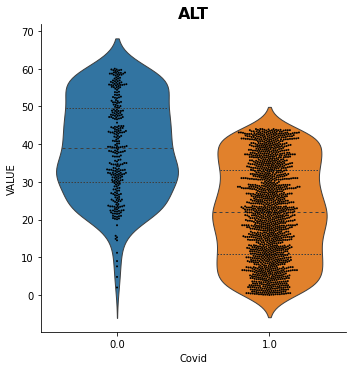

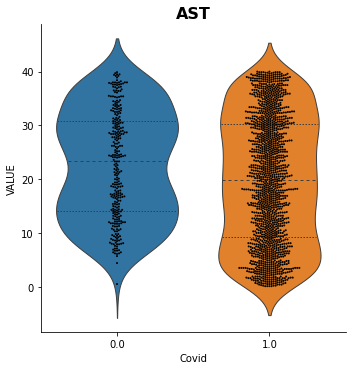

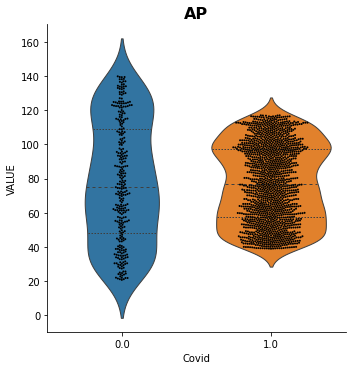

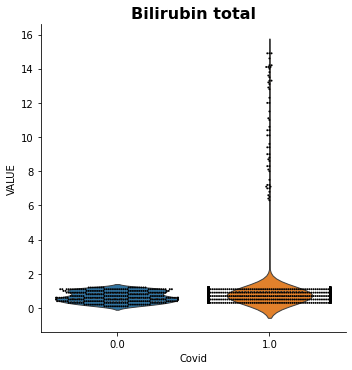

In [29]:
#Plotting der Leberparameter
ALT= dffinal[dffinal['CODE'] == "1742-6"]
AST= dffinal[dffinal['CODE'] == "1920-8"]
AP= dffinal[dffinal['CODE'] == "6768-6"]
Bili= dffinal[dffinal['CODE'] == "1975-2"]

g = sns.catplot(data=ALT, x="Covid", y="VALUE", kind="violin", inner="quart", linewidth=1)
sns.swarmplot(data=ALT, x="Covid", y="VALUE", color="k", size=2, ax=g.ax)
plt.title('ALT', weight='bold').set_fontsize('16')

g = sns.catplot(data=AST, x="Covid", y="VALUE", kind="violin", inner="quart", linewidth=1)
sns.swarmplot(data=AST, x="Covid", y="VALUE", color="k", size=2, ax=g.ax)
plt.title('AST', weight='bold').set_fontsize('16')

g = sns.catplot(data=AP, x="Covid", y="VALUE", kind="violin", inner="quart", linewidth=1)
sns.swarmplot(data=AP, x="Covid", y="VALUE", color="k", size=2, ax=g.ax)
plt.title('AP', weight='bold').set_fontsize('16')

g = sns.catplot(data=Bili, x="Covid", y="VALUE", kind="violin", inner="quart", linewidth=1)
sns.swarmplot(data=Bili, x="Covid", y="VALUE", color="k", size=2, ax=g.ax)
plt.title('Bilirubin total', weight='bold').set_fontsize('16')

**Vorbereitung der Daten für den Classifier**

In [30]:
# import python packages for ML models
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [31]:
dfpred = dffinal.pivot_table('VALUE', ['patient_id',"DATE", "Covid"], 'DESCRIPTION')
dfpred.head(3)

DESCRIPTION                                            Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma  ...  Urea nitrogen [Mass/volume] in Serum or Plasma
patient_id                           DATE       Covid                                                                           ...                                                
0033cec2-67d3-39ec-b0f4-29f91a2918d6 2020-03-10 1.0                                                  NaN                        ...                                             NaN
00680fcd-0ef2-99c5-f69d-59463206750f 2020-03-12 1.0                                                 25.3                        ...                                            15.5
                                     2020-03-13 1.0                                                 22.0                        ...                                            15.5

[3 rows x 15 columns]

In [32]:
dfpred = dfpred.drop(["Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma", "Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma", "Bilirubin.total [Mass/volume] in Serum or Plasma", 'Body temperature', "Diastolic Blood Pressure", "Estimated Glomerular Filtration Rate", "Oxygen [Partial pressure] in Arterial blood", "Oxygen saturation in Arterial blood","Protein [Mass/volume] in Serum or Plasma","Systolic Blood Pressure", "Urea nitrogen [Mass/volume] in Serum or Plasma" ], axis=1)
dfpred = dfpred.reset_index()
dfpred.rename(columns={"Glomerular filtration rate/1.73 sq M.predicted": 'GFR', "Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma":  "ALT", "Heart rate": "Heart_rate", "Respiratory rate": "Respiratory_rate"}, inplace=True)
dfpred.tail(3)

DESCRIPTION,patient_id,DATE,Covid,ALT,GFR,Heart_rate,Respiratory_rate
3561,ffd905f3-45fb-b2a7-7429-bf864ef29d81,2020-03-19,1.0,NaN,NaN,NaN,NaN
3562,ffd905f3-45fb-b2a7-7429-bf864ef29d81,2020-03-20,1.0,NaN,NaN,NaN,NaN
3563,ffe52b9f-cdf1-d315-9286-e64d370edde4,2020-02-24,0.0,NaN,NaN,177.2,24.7


In [33]:
dfpred= dfpred.dropna(thresh=4)

In [34]:
dfpred.groupby(["Covid"]).size()

Covid
0.0    1053
1.0    2278
dtype: int64

In [35]:
#Exkurs: Fallenlassen von Zeilen mit NaN-Werten reduziert die Kontrollgruppe in nicht tolerierbarem Maße (d.h. die vier Parameter wurden so gut wie nie gleichzeitig bestimmt)
dfpnull = dfpred.dropna()
dfpnull.groupby(["Covid"]).size()

#Es muss daher ein Algorithmus zur Vorhersage verwendet werden, der NaN-Werte akzeptiert --> XGBoost

Covid
0.0       6
1.0    1528
dtype: int64

In [36]:
# Mischen der Daten

dfpred= dfpred.sample(frac=1)

In [37]:
# Splitten der Daten in train und test Dataframes
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Ausgabe der Shapes von train und test Dataframes
dfpred_train, dfpred_test = train_test_split(dfpred, test_size=test_ratio, random_state=0)
dfpred_train.shape, dfpred_test.shape

((2831, 7), (500, 7))

In [38]:
# Bestimmen der Features und des Zielwertes
X = dfpred_train.drop(["patient_id", "Covid","DATE"], axis=1)
y = dfpred_train["Covid"]

# Zusätzlich Erstellen eines Validation Dataframes
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_ratio, random_state=0)

X_train.shape, X_val.shape

((2406, 4), (425, 4))

**Vorhersage mit XGBoost**

In [39]:
# Erstellen des Parameter Grid Search
param_grid = {
    'learning_rate': [0.05, 0.5], #so called `eta` value    
    'max_depth': [2, 5, 10, 15],
    'colsample_bytree': [0.4],
    # "objective" :["reg:tweedie"],
    'gamma':[0],               
    'min_child_weight':[1.5],
    'n_estimators' : [5, 10],                                                                    
    'reg_alpha': [0.75],
    'reg_lambda' : [0.45],
    'subsample' : [0.6],
    'seed' : [42]
}
   
# Erstellen des Models
xgb = XGBClassifier()
# Initiieren des Grid Searches
grid_search_xgb = GridSearchCV(estimator = xgb, 
                               param_grid=param_grid,
                               cv=3,
                               n_jobs=-1,
                               verbose=2)

In [40]:
# Anpassen der Daten an den Grid Search
grid_search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.4], 'gamma': [0],
                         'learning_rate': [0.05, 0.5],
                         'max_depth': [2, 5, 10, 15], 'min_child_weight': [1.5],
                         'n_estimators': [5, 10], 'reg_alpha': [0.75],
                         'reg_lambda': [0.45], 'seed': [42],
                         'subsample': [0.6]},
             verbose=2)

In [41]:
# Beste Parameter nach Grid Search
grid_search_xgb.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_weight': 1.5,
 'n_estimators': 10,
 'reg_alpha': 0.75,
 'reg_lambda': 0.45,
 'seed': 42,
 'subsample': 0.6}

In [42]:
# Beste Model
best_grid_xgb = grid_search_xgb.best_estimator_

# Evaluiierung für die Train Daten
pred_train_xgb = best_grid_xgb.predict(X_train)
print('Accuracy for train data:', accuracy_score(y_train, pred_train_xgb))  

# Evaluiierung für die Test Daten
pred_test_xgb = best_grid_xgb.predict(X_val)
acc_xgb = round(accuracy_score(y_val, pred_test_xgb), 5)
print('Accuracy for test data:', acc_xgb)

Accuracy for train data: 0.987115544472153
Accuracy for test data: 0.98118


In [43]:
# Hinzufügen des Prediction Ergebnisses zur Ausgangstabelle
selected_columns = X.columns
x_test = dfpred_test[X.columns]
dfpred_test["XGB_prediction"] = best_grid_xgb.predict(x_test)
dfpred_test.head(5)


DESCRIPTION,patient_id,DATE,Covid,ALT,GFR,Heart_rate,Respiratory_rate,XGB_prediction
69,055460a6-cdac-2a76-59e6-b3aaede84ed6,2020-03-02,1.0,NaN,NaN,98.8,12.5,1.0
2674,bf908612-a55f-398e-d1d7-ec3366216261,2020-03-06,1.0,NaN,NaN,179.5,27.8,1.0
1433,6774ab21-6678-ca68-111e-46c956e72872,2020-03-13,1.0,NaN,NaN,66.8,24.7,1.0
2365,a9d59f93-9196-3e40-88c3-a51f8c80802c,1973-10-12,0.0,NaN,NaN,96.0,13.0,0.0
2638,bd4c46f4-f960-9215-dbc1-3a19c72c4c32,2020-03-07,1.0,NaN,NaN,134.9,17.8,1.0


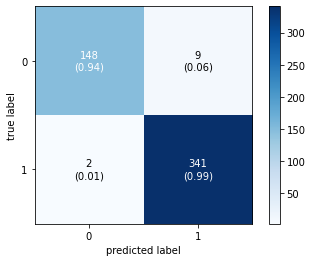

In [44]:
# Erstellen einer Confusion-Matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_actu = dfpred_test["Covid"]
y_pred = dfpred_test["XGB_prediction"]
cf_matrix = confusion_matrix(y_actu, y_pred)

classes = ['class A', 'class B']
figure, ax = plot_confusion_matrix(conf_mat = cf_matrix,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True)
plt.show()

In [45]:
# Darstellen der inkorrekt klassifizierten Daten
incorrect = dfpred_test[dfpred_test["Covid"] != dfpred_test["XGB_prediction"]]
incorrect.head(30)

DESCRIPTION,patient_id,DATE,Covid,ALT,GFR,Heart_rate,Respiratory_rate,XGB_prediction
1051,4111b8a5-2bde-26e3-0a51-2ceca8a21401,2020-03-06,1.0,NaN,NaN,78.0,16.1,0.0
3563,ffe52b9f-cdf1-d315-9286-e64d370edde4,2020-02-24,0.0,NaN,NaN,177.2,24.7,1.0
1880,8a02814e-f62d-6816-9bcb-6ede894bb469,2020-03-08,0.0,NaN,NaN,182.9,34.6,1.0
2558,b9769ab3-c2bd-f137-bb15-38e76467ab2e,2020-03-08,0.0,NaN,NaN,68.3,20.9,1.0
3335,e7e2021f-c0ef-e912-4177-03c8f56e7219,2020-03-08,0.0,NaN,NaN,109.5,32.4,1.0
796,26d353df-e9af-35b0-b694-af604d610bd9,2020-03-08,1.0,38.3,89.7,74.5,14.0,0.0
3511,fcba964d-5bc8-6637-3f8b-2cabb57f23bc,2020-03-10,0.0,NaN,NaN,126.3,14.8,1.0
246,178318a5-6b9d-5668-d4da-52159a9804b7,2020-02-28,0.0,NaN,NaN,78.1,32.5,1.0
1833,833b2665-8682-7b37-b685-848b3d981e02,2020-03-07,0.0,NaN,NaN,136.5,34.6,1.0
2965,d07c6a46-cc40-8fc9-10e6-8757ba29806a,2020-03-15,0.0,NaN,NaN,188.4,20.5,1.0


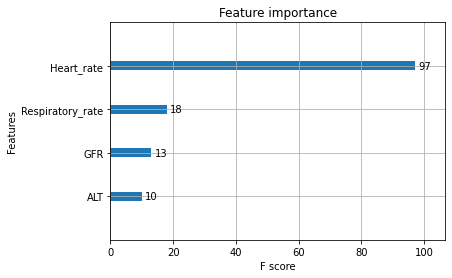

In [46]:
# Darstellen der Feature importance
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(best_grid_xgb)
pyplot.show()

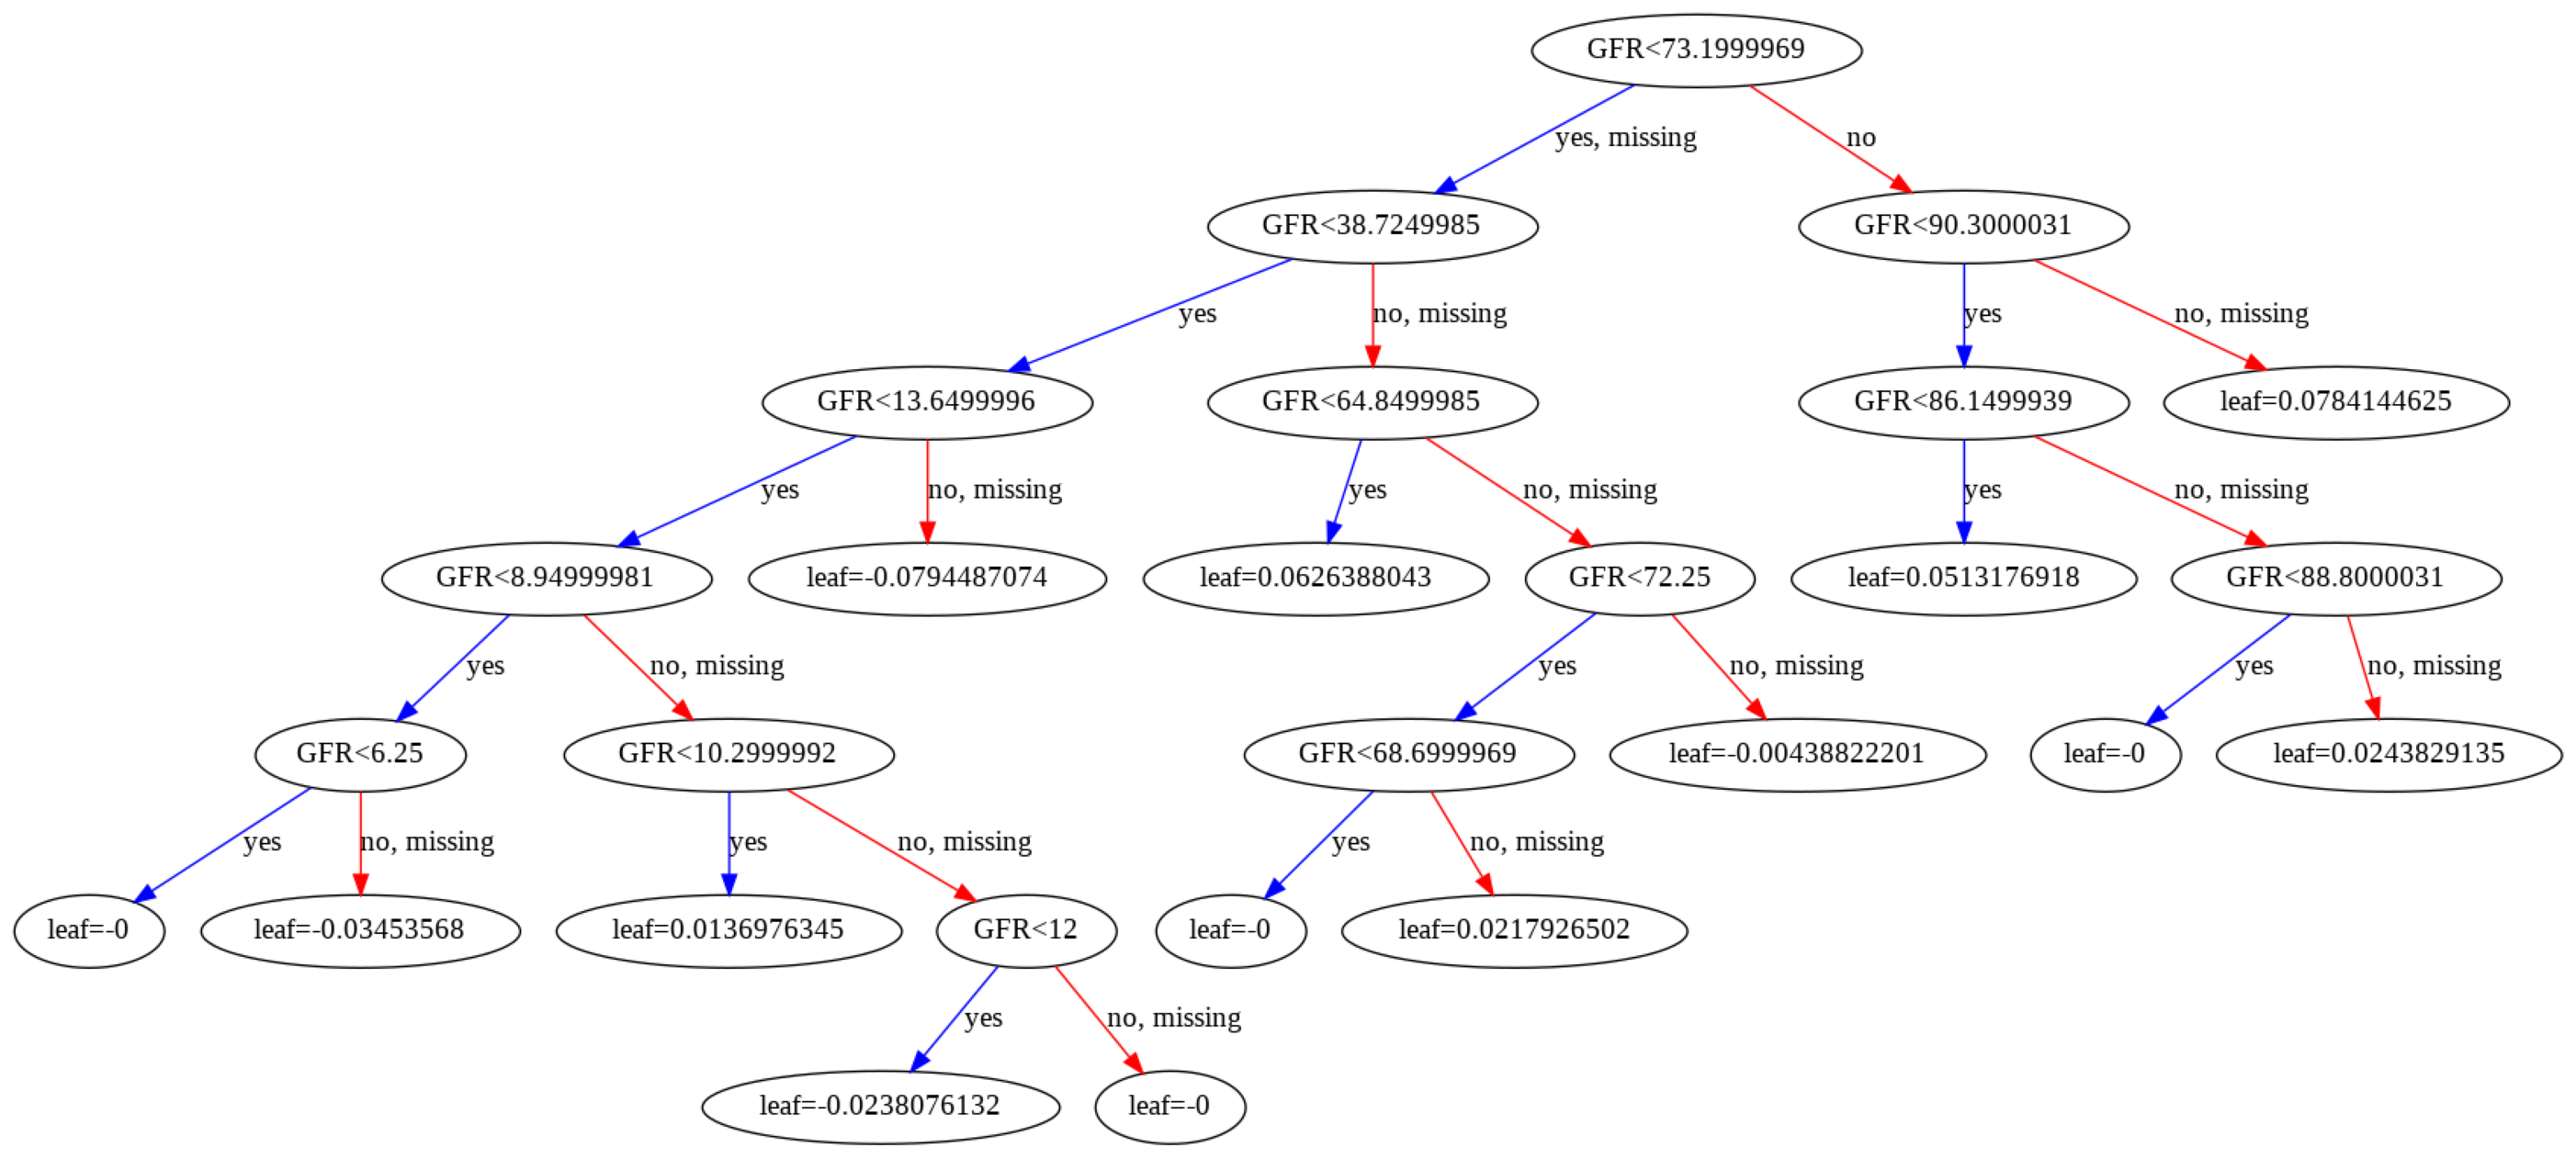

In [47]:
# Beispielhaftes Darstellen des Decision Trees für die GFR
from xgboost import plot_tree
plot_tree(best_grid_xgb, num_trees=6)
fig = plt.gcf()
fig.set_size_inches(50, 30)